In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

# I. Wrangle Data

In [2]:
import pandas as pd

In [71]:
def wrangle(filepath):
    # Import CSV, set issue date to index
    df = pd.read_csv(filepath, 
                     parse_dates=['issue_d'],
                     index_col='issue_d').sort_index()
    
    # Just use 36 month loans
    df = df[df.term ==' 36 months']
    
    # Clean data col names
    df = df.rename(columns=                     
        {'annual_inc': 'annual_income', 
         'fico_range_high': 'credit_score', 
         'funded_amnt': 'loan_amount', 
         'title': 'loan_purpose'}) 
    
    # Engineer features
    df['interest_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['monthly_debts'] = df['annual_income'] / 12 * df['dti'] / 100
    
    # Select features for FM
    cols = ['annual_income',
            'credit_score',
            'interest_rate',
            'loan_amount',
            'loan_purpose',
            'monthly_debts']
    
    df = df[cols]
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    # Cleaning / engineering features from `loan_purpose`
    
    ## Lowercase `loan_purpose`
    df['loan_purpose'] = df['loan_purpose'].str.lower().str.strip()
    
    ## Add loan purpose "OHE"
    key_words = ['credit card', 'consolida', 'home', 'medical',
                 'vacation', 'moving', 'car ', 'personal']
    
    for word in key_words:
        df[f'purpose_{word}'] = df['loan_purpose'].str.contains(word).astype(int)
    
    ## Drop loan purpose
    df.drop(columns='loan_purpose', inplace=True)
    
    # Remove rows where salary is more than $1 million
    df = df[df['annual_income'] < 250_000]
    
    return df

In [72]:
df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [73]:
df.shape

(100310, 13)

In [74]:
df.head()

,annual_income,credit_score,interest_rate,loan_amount,monthly_debts,purpose_credit card,purpose_consolida,purpose_home,purpose_medical,purpose_vacation,purpose_moving,purpose_car,purpose_personal
issue_d,,,,,,,,,,,,,
2007-07-01,20000.0,684.0,10.28,3500.0,25.000000,0,0,0,0,0,0,0,0
2007-07-01,95000.0,774.0,7.43,5000.0,303.208333,0,0,0,0,0,0,0,0
2007-07-01,150000.0,779.0,7.43,5000.0,0.000000,0,0,0,0,0,0,0,0
2007-07-01,200000.0,679.0,10.28,3000.0,0.000000,0,0,0,0,0,0,0,0
2007-08-01,61800.0,749.0,7.75,4000.0,178.190000,0,0,0,0,0,0,0,0


# II. Split Data

Split **feature matrix** from **target vector**

In [75]:
target = 'interest_rate'
y = df[target]
X = df.drop(columns=target)

Split dataset into **training** and **test** sets

In [82]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# III. Establish Baseline

In [84]:
from sklearn.metrics import mean_absolute_error
print('Mean Interest:', y_train.mean())
y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean Interest: 11.570150034891837
Baseline MAE: 2.892519869667116


# III. Build Model

In [85]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [86]:
model_boost = XGBRegressor(n_estimators=20, random_state=42)
model_boost.fit(X_train, y_train)

model_forest = RandomForestRegressor(n_estimators=20, random_state=42)
model_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20, random_state=42)

# IV. Check Metrics 

In [87]:
for model in [model_forest, model_boost]:
    print(type(model))
    print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
    print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))
    print()

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Training MAE: 0.9023070455694485
Test MAE: 2.770784247997873

<class 'xgboost.sklearn.XGBRegressor'>
Training MAE: 2.1824575807560764
Test MAE: 2.63663229707207



# V. Communicate Results

## Partial Dependence Plot (PDP Plot)

One feature

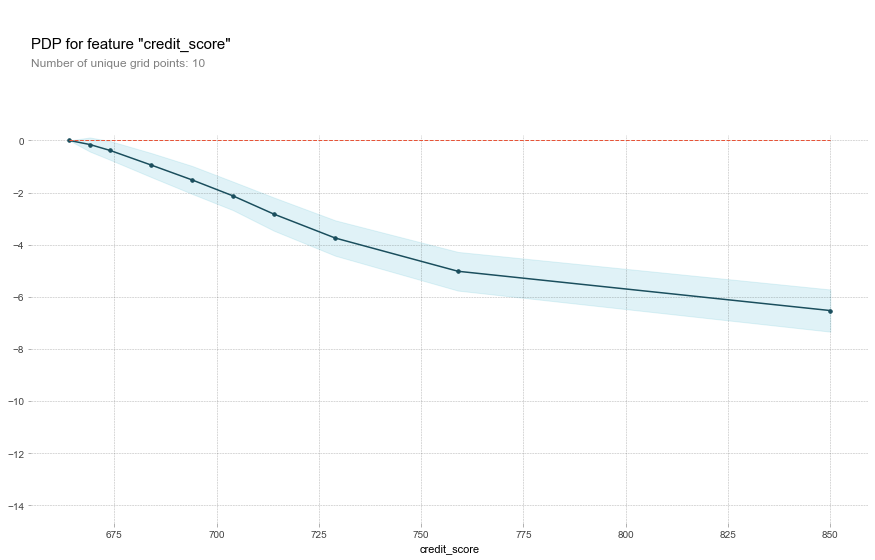

In [88]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'credit_score'

# Build your `pdp_isolate`
isolate = pdp_isolate(
    model=model_boost,
    dataset=X_test, #<-- Always use with VALIDATION or TEST data
    model_features=X_test.columns,
    feature=feature
)

# Build your plot
pdp_plot(isolate, feature_name=feature);

Two features

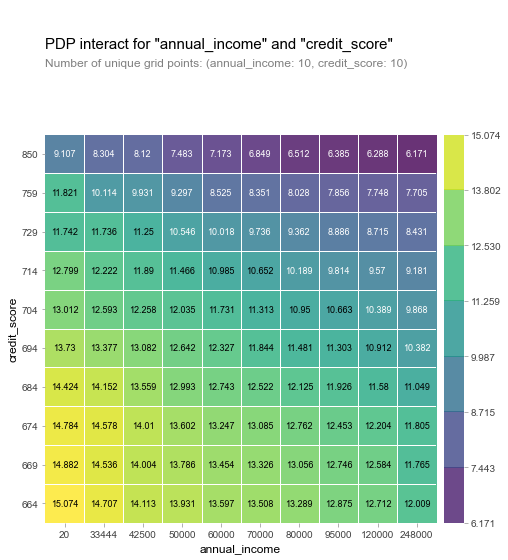

In [91]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['annual_income', 'credit_score']

interact = pdp_interact(
    model=model_boost,
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

## Shapley

- Show you the influence of features on *individual* predictions

In [97]:
# Grab a single observation from our test data
row = X_test.iloc[[142]]
row

,annual_income,credit_score,loan_amount,monthly_debts,purpose_credit card,purpose_consolida,purpose_home,purpose_medical,purpose_vacation,purpose_moving,purpose_car,purpose_personal
issue_d,,,,,,,,,,,,
2016-12-01,34000.0,684.0,6025.0,548.816667,0,1,0,0,0,0,0,0


In [98]:
# What does our model predict for this observation?
model_boost.predict(row)

array([12.745776], dtype=float32)

In [99]:
from shap import TreeExplainer, initjs, force_plot

explainer = TreeExplainer(model_boost) # <-- Does not like `sklearn` pipelines

initjs()

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(row),
    features=row
)